<a href="https://colab.research.google.com/github/choudhurysibani120/NYC-Trip-Time-Prediction/blob/main/sibani_choudhury_NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

In [ ]:
# Importing the libraries
import numpy as np
import pandas as pd
from numpy import math
import xgboost
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import warnings
from pylab import rcParams
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the data

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Copy of NYC Taxi Data.csv')

Peeking at the data

In [ ]:
data.shape

(1458644, 11)

There are 1458644 rows and 11 columns

In [ ]:
data.head()

id  vendor_id  ... store_and_fwd_flag trip_duration
0  id2875421          2  ...                  N           455
1  id2377394          1  ...                  N           663
2  id3858529          2  ...                  N          2124
3  id3504673          2  ...                  N           429
4  id2181028          2  ...                  N           435

[5 rows x 11 columns]

In [ ]:
# checking data-types of variables to identify the numerical and categorical variables
data.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object


Categorizing the features :¶

Let's divide features into categories:

Geographical: pickup_longitude , pickup_latitude , dropoff_longitude , dropoff_latitude

Time related: pickup_datetime, dropoff_datetime

Identifier: id(not useful for analysis)

Others: vendor_id, passenger_count, store_and_fwd_flag

Target: trip_duration

In [ ]:
data.describe()

vendor_id  passenger_count  ...  dropoff_latitude  trip_duration
count  1.458644e+06     1.458644e+06  ...      1.458644e+06   1.458644e+06
mean   1.534950e+00     1.664530e+00  ...      4.075180e+01   9.594923e+02
std    4.987772e-01     1.314242e+00  ...      3.589056e-02   5.237432e+03
min    1.000000e+00     0.000000e+00  ...      3.218114e+01   1.000000e+00
25%    1.000000e+00     1.000000e+00  ...      4.073588e+01   3.970000e+02
50%    2.000000e+00     1.000000e+00  ...      4.075452e+01   6.620000e+02
75%    2.000000e+00     2.000000e+00  ...      4.076981e+01   1.075000e+03
max    2.000000e+00     9.000000e+00  ...      4.392103e+01   3.526282e+06

[8 rows x 7 columns]

Pasenger count varies from 0 to 9.
Trip duration has max value of 3526282 seconds almost 979.5 hours and minimum 1 second. This definetly has outliers present so we'll remove them

NAN or Missing Values

It is wise to check for any missing value present in our dataset as many modelling procedures may break down. if there's any missing value present in our dataset the corresponding rows will either have to be removed completely from dataset or the values need to be estimated somehow

In [ ]:

data['trip_duration'].isnull().sum()

0

In [ ]:

data.drop_duplicates(inplace=True)
data.shape

(1458644, 11)

There are no null values and duplicate data.

In [ ]:
data['passenger_count'].value_counts().reset_index()

index  passenger_count
0      1          1033540
1      2           210318
2      5            78088
3      3            59896
4      6            48333
5      4            28404
6      0               60
7      7                3
8      9                1
9      8                1

In [ ]:
data[data['passenger_count']==0].count()

id                    60
vendor_id             60
pickup_datetime       60
dropoff_datetime      60
passenger_count       60
pickup_longitude      60
pickup_latitude       60
dropoff_longitude     60
dropoff_latitude      60
store_and_fwd_flag    60
trip_duration         60
dtype: int64

In [ ]:
data=data[data['passenger_count']!=0]

In [ ]:
data["pickup_datetime"][0]

'2016-03-14 17:24:55'

In [ ]:

data['pickup_datetime']=pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime']=pd.to_datetime(data['dropoff_datetime'])
data.head()

id  vendor_id  ... store_and_fwd_flag trip_duration
0  id2875421          2  ...                  N           455
1  id2377394          1  ...                  N           663
2  id3858529          2  ...                  N          2124
3  id3504673          2  ...                  N           429
4  id2181028          2  ...                  N           435

[5 rows x 11 columns]

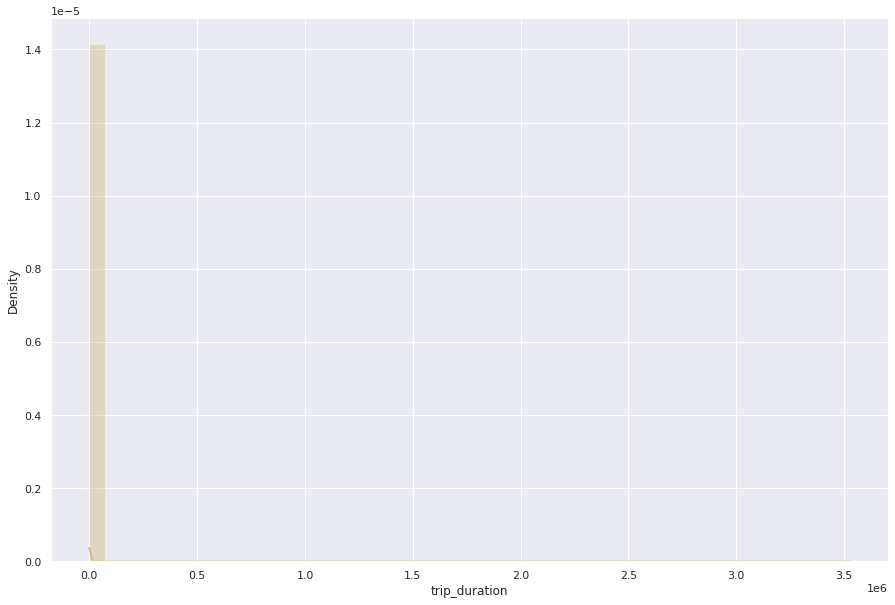

In [ ]:
#Dependent variable 'trip_duration'
plt.figure(figsize=(15,10))
sns.distplot(data['trip_duration'],color="y")

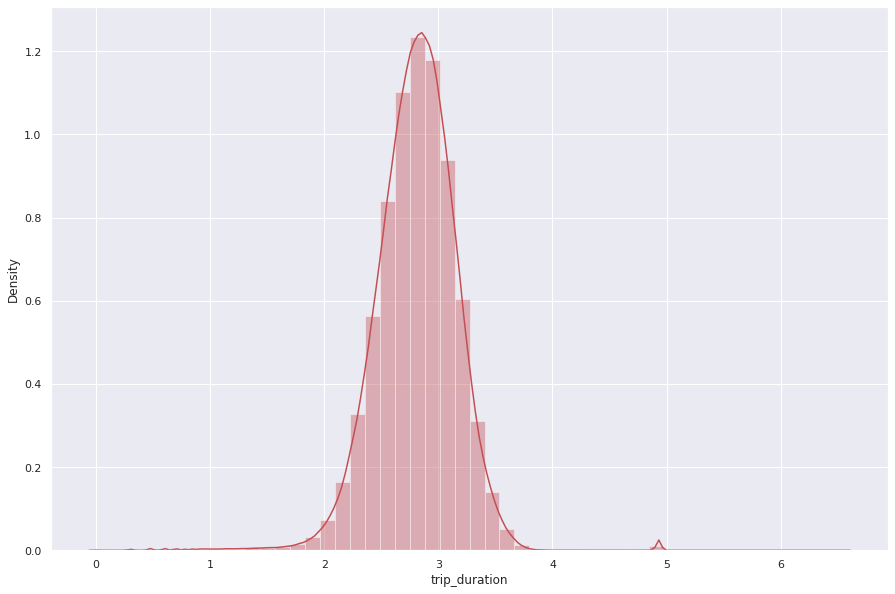

In [ ]:
plt.figure(figsize=(15,10))
sns.distplot(np.log10(data['trip_duration']),color="R")

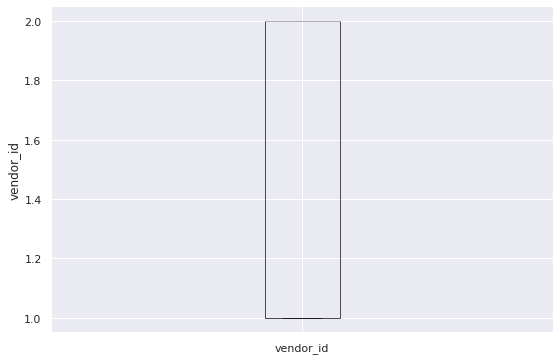

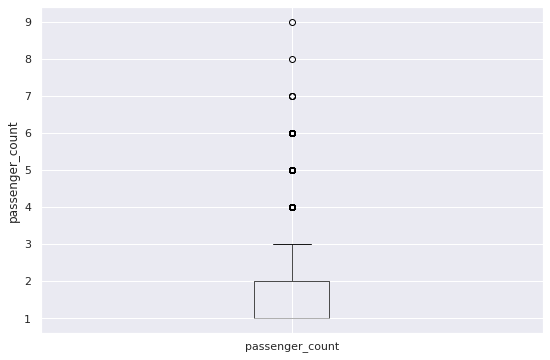

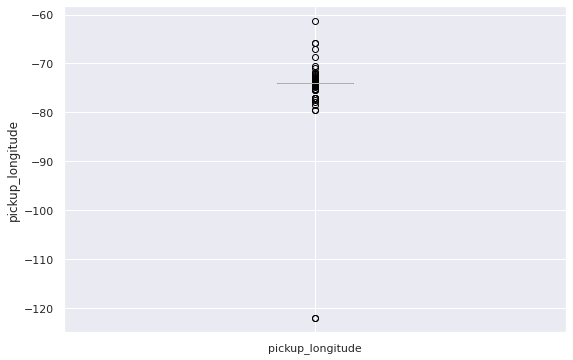

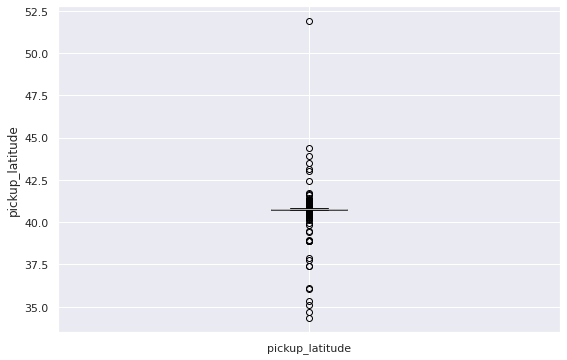

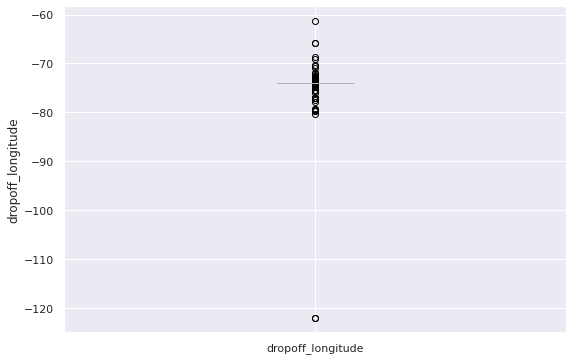

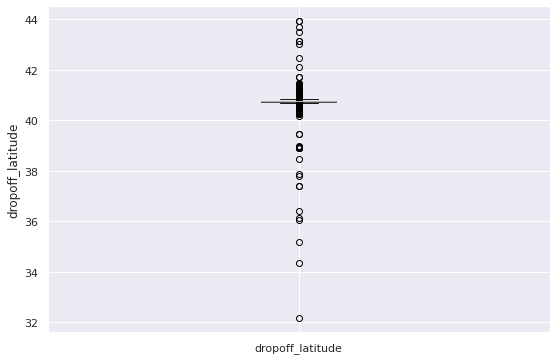

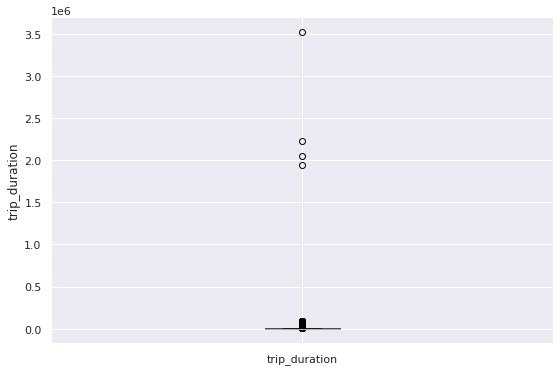

In [ ]:
# plot a boxplot for the label by each numerical feature  
for col in data.describe().columns:
  fig = plt.figure(figsize=(9, 6))
  ax = fig.gca()
  data.boxplot(column = col, ax = ax)
  ax.set_ylabel(col)
plt.show()

Vendor ID has no outlier.

In passenger count 4 and more passengers are being treated as outliers.

pickup_longitude and pickup_latitude has outliers as well.

dropoff_longitude and dropoff_latitude has outliers too.

Our target variable trip_duration has alot of outliers

In [ ]:
numeric_features = data.describe().columns
numeric_features

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration'],
      dtype='object')

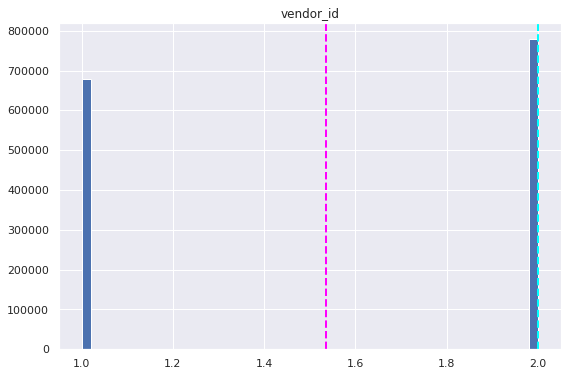

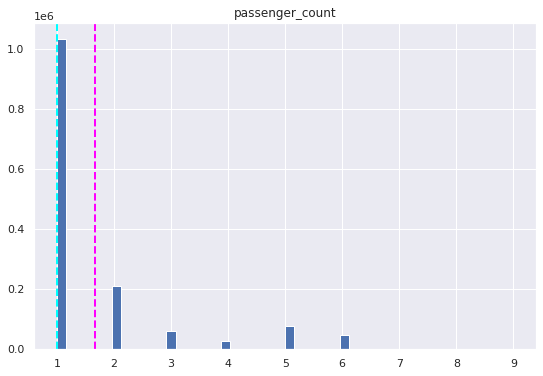

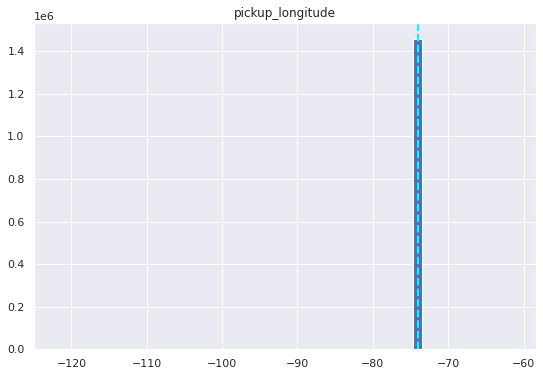

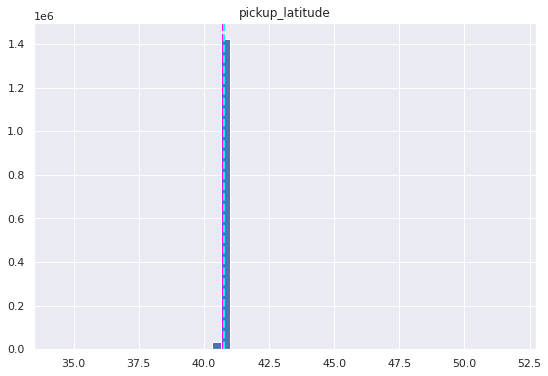

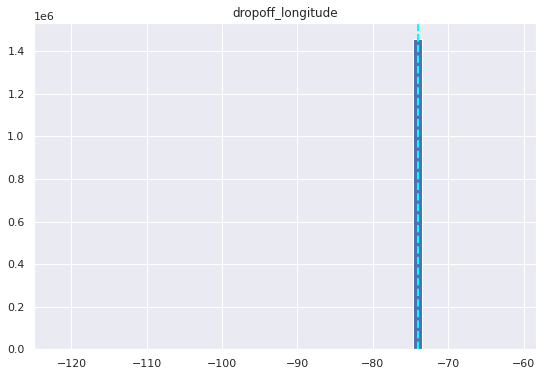

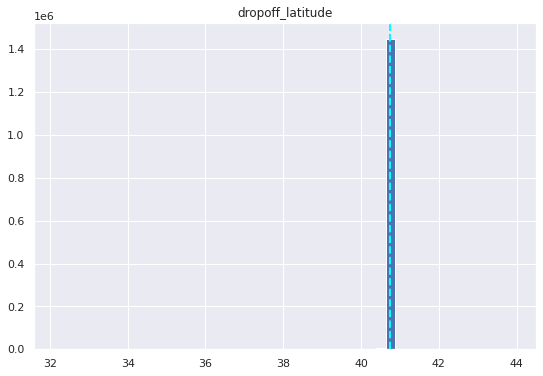

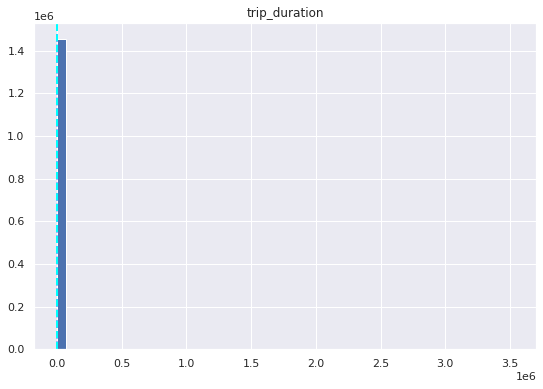

In [ ]:
# plot a bar plot for each numerical feature count
for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = data[col]
    feature.hist(bins=50, ax = ax)
    ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)    
    ax.set_title(col)
plt.show()

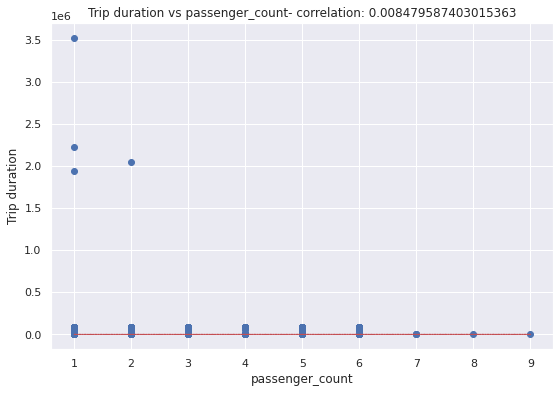

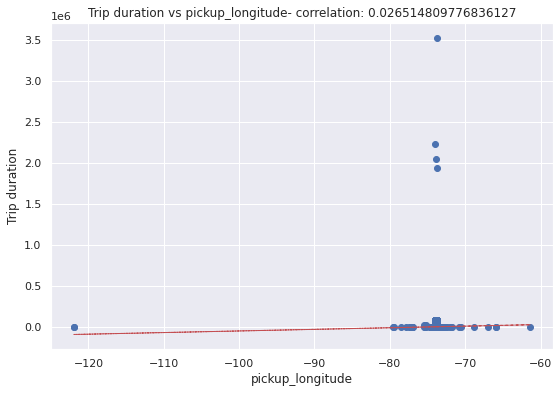

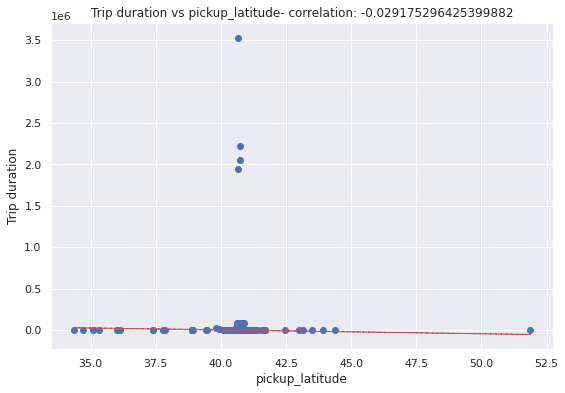

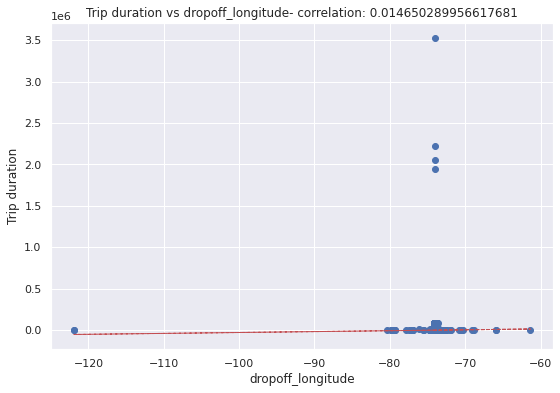

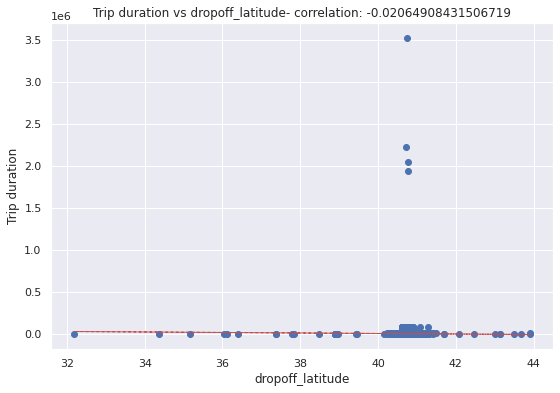

In [ ]:

for col in numeric_features[1:-1]:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = data[col]
    label = data['trip_duration']
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('Trip duration')
    ax.set_title('Trip duration vs ' + col + '- correlation: ' + str(correlation))
    z = np.polyfit(data[col], data['trip_duration'], 1)
    y_hat = np.poly1d(z)(data[col])

    plt.plot(data[col], y_hat, "r--", lw=1)

plt.show()

(-74.03, -73.75)

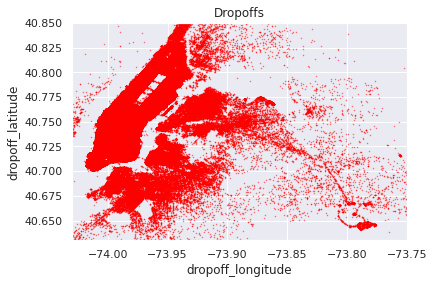

In [ ]:
city_long_border = [-74.03, -73.75]
city_lat_border = [40.63,40.85]

data.plot(kind='scatter', x='dropoff_longitude',y='dropoff_latitude',
          color='Red',
          s=0.2, alpha =.6)
plt.title('Dropoffs')

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

(-74.03, -73.75)

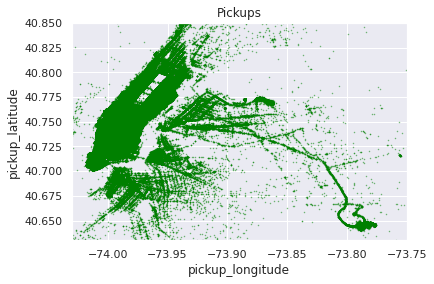

In [ ]:
city_long_border = [-74.03, -73.75]
city_lat_border = [40.63,40.85]

data.plot(kind='scatter', x='pickup_longitude',y='pickup_latitude',
          color='green',
          s=0.2, alpha =.6)
plt.title('Pickups')

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

In [ ]:
def select_within_boundingbox(df, BB):
    return ((data["pickup_longitude"] >= BB[0]) & (data["pickup_longitude"] <= BB[1]) & 
            (data["pickup_latitude"] >= BB[2]) & (data["pickup_latitude"] <= BB[3]) &
            (data["dropoff_longitude"] >= BB[0]) & (data["dropoff_longitude"] <= BB[1]) &
            (data["dropoff_latitude"] >= BB[2]) & (data["dropoff_latitude"] <= BB[3]))
BB = (-74.3, -73.0, 40.6, 41.7)

In [ ]:
import folium

In [ ]:
nyc = folium.Map(location=[40.730610,-73.935242],zoom_start=12,)
nyc

In [ ]:
for i in data.index[:100]:
  folium.CircleMarker(location=[data['pickup_latitude'][i],data['pickup_longitude'][i]],color='green').add_to(nyc)
nyc

In [ ]:
for i in data.index[:100]:
  folium.CircleMarker(location=[data['dropoff_latitude'][i],data['dropoff_longitude'][i]],color='red').add_to(nyc)
nyc

FEATURE ENGINEERING

In [ ]:
data['pickup_day']=data['pickup_datetime'].dt.day_name()
data['dropoff_day']=data['dropoff_datetime'].dt.day_name()
data.head()

id  vendor_id  ... pickup_day dropoff_day
0  id2875421          2  ...     Monday      Monday
1  id2377394          1  ...     Sunday      Sunday
2  id3858529          2  ...    Tuesday     Tuesday
3  id3504673          2  ...  Wednesday   Wednesday
4  id2181028          2  ...   Saturday    Saturday

[5 rows x 13 columns]

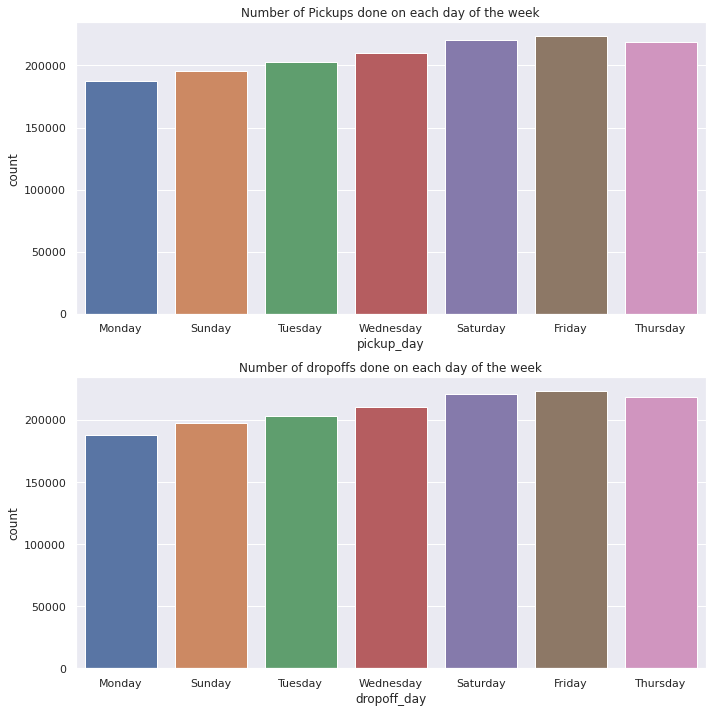

In [ ]:
figure,ax=plt.subplots(nrows=2,ncols=1,figsize=(10,10))
sns.countplot(x='pickup_day',data=data,ax=ax[0])
ax[0].set_title('Number of Pickups done on each day of the week')
sns.countplot(x='dropoff_day',data=data,ax=ax[1])
ax[1].set_title('Number of dropoffs done on each day of the week')
plt.tight_layout()

Thus we see most trips were taken on Friday and Monday being the least. The distribution of trip duration with the days of the week is something to look into as well.

In [ ]:
bins=np.array([0,1800,3600,5400,7200,90000])
data['duration_time']=pd.cut(data.trip_duration,bins,labels=["< 5", "5-10", "10-15","15-20",">20"])

In [ ]:

import datetime
def timezone(x):
    if x>=datetime.time(4, 0, 1) and x <=datetime.time(10, 0, 0):
        return 'morning'
    elif x>=datetime.time(10, 0, 1) and x <=datetime.time(16, 0, 0):
        return 'midday'
    elif x>=datetime.time(16, 0, 1) and x <=datetime.time(22, 0, 0):
        return 'evening'
    elif x>=datetime.time(22, 0, 1) or x <=datetime.time(4, 0, 0):
        return 'late night'
    
data['pickup_timezone']=data['pickup_datetime'].apply(lambda x :timezone(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )
data['dropoff_timezone']=data['dropoff_datetime'].apply(lambda x :timezone(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )

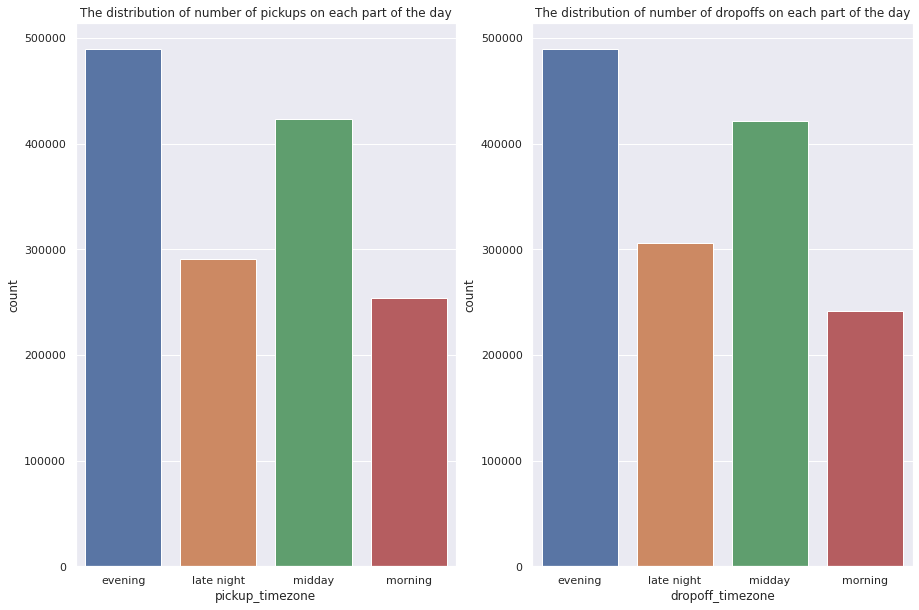

In [ ]:

figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,10))
sns.countplot(x='pickup_timezone',data=data,ax=ax[0])
ax[0].set_title('The distribution of number of pickups on each part of the day')
sns.countplot(x='dropoff_timezone',data=data,ax=ax[1])
ax[1].set_title('The distribution of number of dropoffs on each part of the day')
plt.show()

In [ ]:
from math import sin, cos, sqrt, atan2, radians

def get_distance(lon_1, lon_2, lat_1, lat_2):

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat_1)
    lon1 = radians(lon_1)
    lat2 = radians(lat_2)
    lon2 = radians(lon_2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

In [ ]:
data["distance"] = data.apply(lambda x: get_distance(x["pickup_longitude"],x["dropoff_longitude"],x["pickup_latitude"],x["dropoff_latitude"]),axis=1)


IQR=Q3-Q1

lower_limit_outlier=Q1-1.5*IQR

upper_limit_outlier=Q3+1.5*IQR¶

so we have to take the values which is greater then lower limit outlier and less then upper limit outlier
remove the outlier present in distance

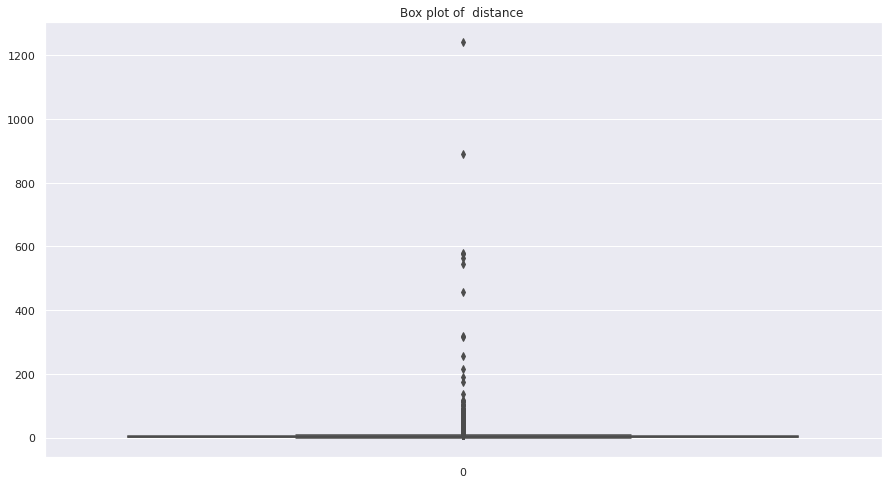

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Box plot of  distance ")
ax = sns.boxplot(data=data['distance'], orient="v")

In [ ]:
percentile_q1 = np.percentile(data['distance'],25)
print(percentile_q1)
percentile_q2 = np.percentile(data['distance'],50)
print(percentile_q2)
percentile_q3 = np.percentile(data['distance'],75)
print(percentile_q3)

1.232295860862315
2.0944392378528622
3.8766616822922098


In [ ]:
iqr=percentile_q3 - percentile_q1
lower_limit_outlier=percentile_q1-1.5*iqr
upper_limit_outlier=percentile_q3+1.5*iqr

print("lower limit for outlier  :",lower_limit_outlier)
print("Upper limit for outlier  :",upper_limit_outlier)

lower limit for outlier  : -2.734252871282527
Upper limit for outlier  : 7.843210414437052


In [ ]:
data=data[data['distance']>lower_limit_outlier]
data=data[data['distance']<upper_limit_outlier]

In [ ]:
data.shape

(1317917, 17)

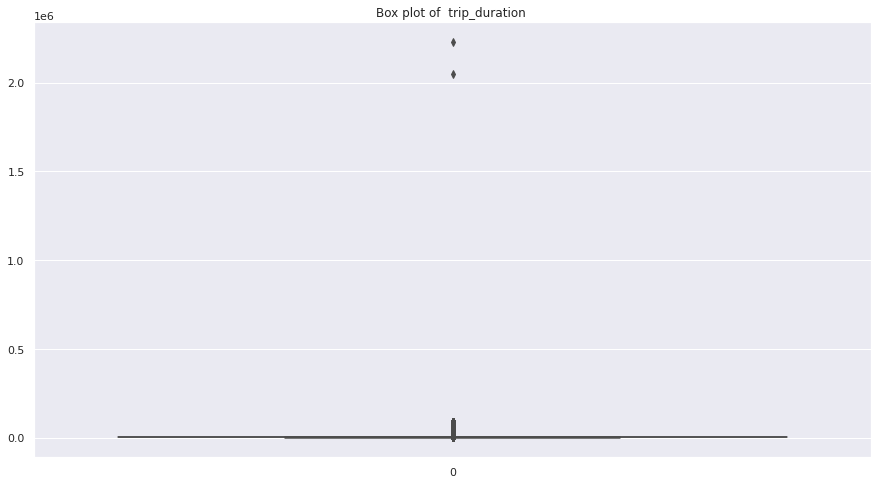

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Box plot of  trip_duration ")
ax = sns.boxplot(data=data['trip_duration'], orient="v")

In [ ]:
percentile_q1_trip_duration = np.percentile(data['trip_duration'],25)
print(percentile_q1_trip_duration)
percentile_q2_trip_duration = np.percentile(data['trip_duration'],50)
print(percentile_q2_trip_duration)
percentile_q3_trip_duration = np.percentile(data['trip_duration'],75)
print(percentile_q3_trip_duration)

373.0
605.0
931.0


In [ ]:

iqr=percentile_q3_trip_duration - percentile_q1_trip_duration
lower_limit_outlier_trip_duration=percentile_q1_trip_duration-1.5*iqr
upper_limit_outlier_trip_duration=percentile_q3_trip_duration+1.5*iqr

print("lower limit for outlier  :",lower_limit_outlier_trip_duration)
print("Upper limit for outlier  :",upper_limit_outlier_trip_duration)

lower limit for outlier  : -464.0
Upper limit for outlier  : 1768.0


In [ ]:

data=data[data['trip_duration']>0]
data=data[data['trip_duration']<upper_limit_outlier_trip_duration]

In [ ]:
data.shape

(1277345, 17)

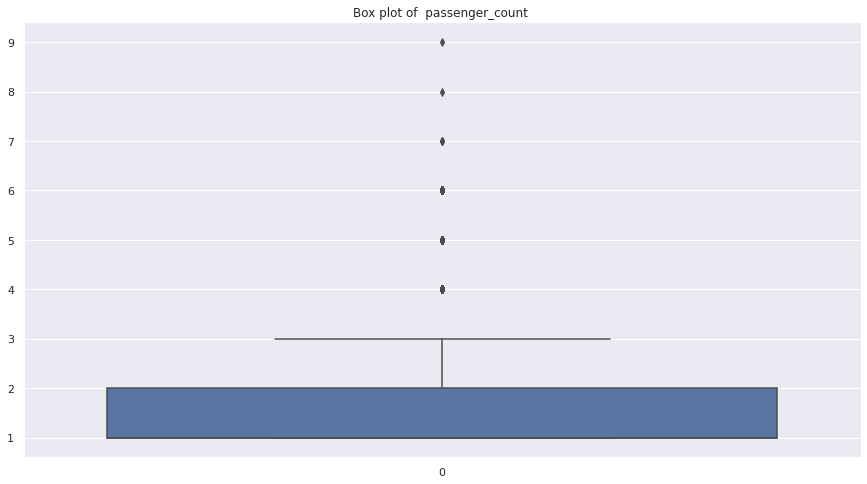

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Box plot of  passenger_count ")
ax = sns.boxplot(data=data['passenger_count'], orient="v")

In [ ]:
percentile_q1_passenger_count = np.percentile(data['passenger_count'],25)
print(percentile_q1_passenger_count)
percentile_q2_passenger_count = np.percentile(data['passenger_count'],50)
print(percentile_q2_passenger_count)
percentile_q3_passenger_count = np.percentile(data['passenger_count'],75)
print(percentile_q3_passenger_count)

1.0
1.0
2.0


In [ ]:
iqr=percentile_q3_passenger_count - percentile_q1_passenger_count
lower_limit_outlier_passenger_count=percentile_q1_passenger_count-1.5*iqr
upper_limit_outlier_passenger_count=percentile_q3_passenger_count+1.5*iqr

print("lower limit for outlier  :",lower_limit_outlier_passenger_count)
print("Upper limit for outlier  :",upper_limit_outlier_passenger_count)

lower limit for outlier  : -0.5
Upper limit for outlier  : 3.5


In [ ]:

data=data[data['passenger_count']>0]
data=data[data['passenger_count']<upper_limit_outlier_passenger_count]

In [ ]:
data.shape

(1142605, 17)

In [ ]:

data["pickup_datetime"] = pd.to_datetime(data["pickup_datetime"], format="%Y-%m-%d %H:%M:%S")

In [ ]:
data['Day']=data['pickup_datetime'].dt.day_name()

In [ ]:
data["year"] = data["pickup_datetime"].apply(lambda x: x.year)
data["month"] = data["pickup_datetime"].apply(lambda x: x.month)
data["day_num"] = data["pickup_datetime"].apply(lambda x: x.day)
data["hour"] = data["pickup_datetime"].apply(lambda x: x.hour)
data["minute"] = data["pickup_datetime"].apply(lambda x: x.minute)

Converting trip duration into hours.

Taking log of our distance for normalisation of data.

Taking log of our trip duration as well to normalize it's data too.

In [ ]:
data['trip_duration_hour']=data['trip_duration']/3600
data['log_distance']=np.log(data.distance)
data['log_trip_duration']=np.log(data.trip_duration_hour)

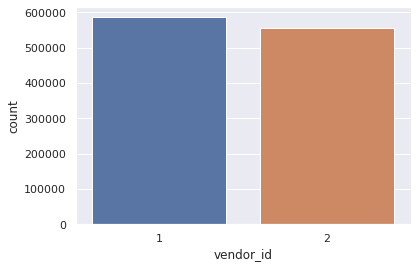

In [ ]:
sns.countplot(x='vendor_id',data=data)

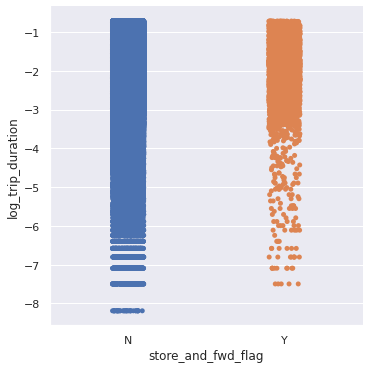

In [ ]:

sns.catplot(x="store_and_fwd_flag", y="log_trip_duration",kind="strip",data=data)

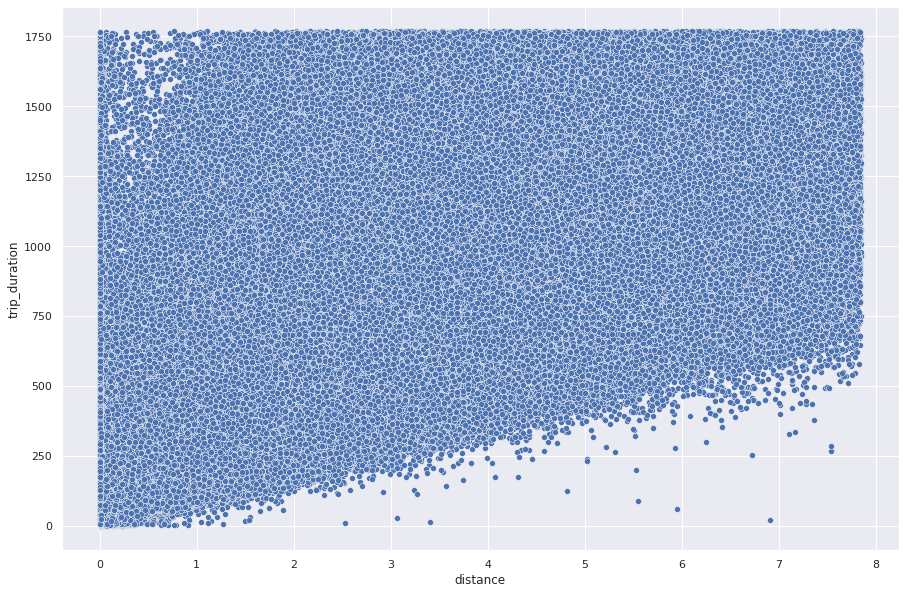

In [ ]:
fig = plt.figure(figsize=(15, 10))
sns.scatterplot(x='distance',y='trip_duration',data=data)

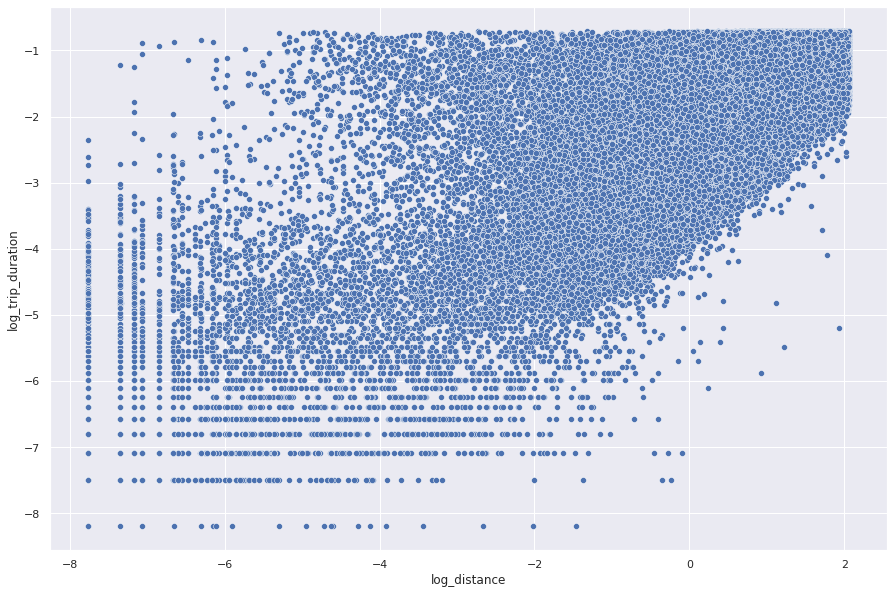

In [ ]:
fig = plt.figure(figsize=(15, 10))
sns.scatterplot(x='log_distance',y='log_trip_duration',data=data)

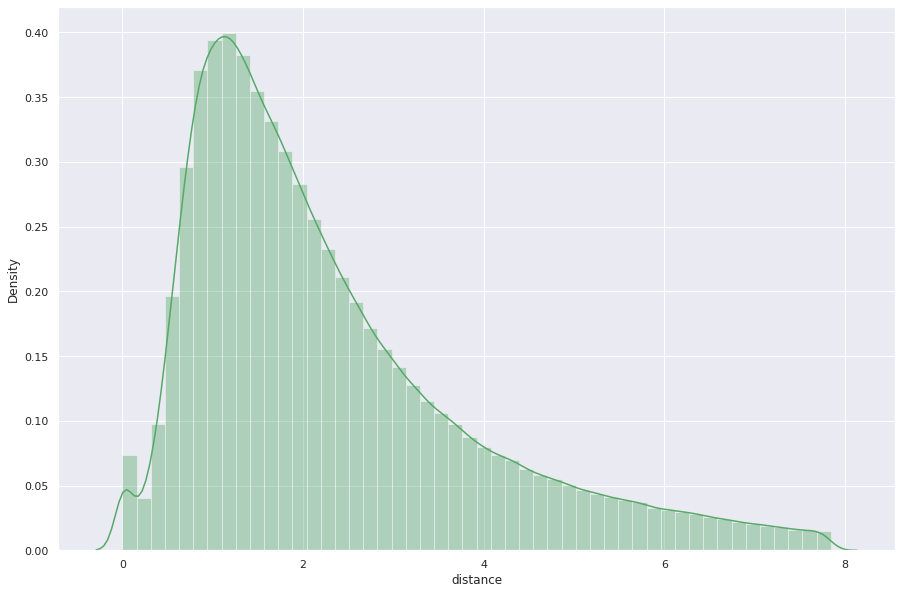

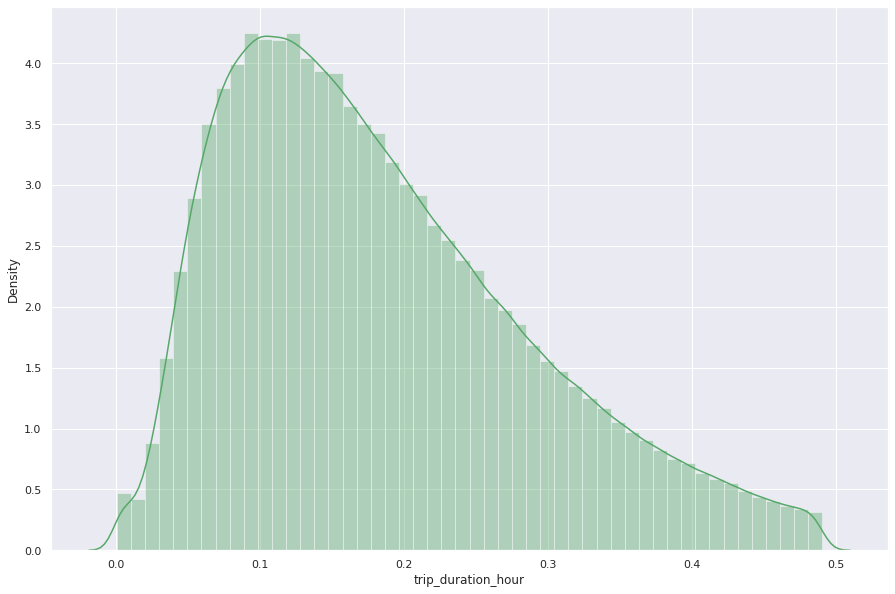

In [ ]:
sample=['distance','trip_duration_hour']
for i in sample:
  plt.figure(figsize=(15,10))
  sns.distplot(data[i],color="g")

In [ ]:
# One hot encoding
data= pd.get_dummies(data, columns=["store_and_fwd_flag", "Day"], prefix=["store_and_fwd_flag",'Day'])

In [ ]:

features=['vendor_id','passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','distance','month','hour','minute',
          'store_and_fwd_flag_N','store_and_fwd_flag_Y','Day_Friday','Day_Monday','Day_Saturday','Day_Sunday','Day_Thursday','Day_Tuesday','Day_Wednesday']

In [ ]:
newdata=['vendor_id','passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','distance','month','hour','minute',
          'store_and_fwd_flag_N','store_and_fwd_flag_Y','Day_Friday','Day_Monday','Day_Saturday','Day_Sunday','Day_Thursday','Day_Tuesday','Day_Wednesday','trip_duration_hour']
trip_data=data[newdata]

In [ ]:

from scipy.stats import zscore
#Train test split
X = data[features].apply(zscore)[:100000]
y=data['trip_duration_hour'][:100000]

In [ ]:
# Importing train_test_split
from sklearn.model_selection import train_test_split

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(80000, 19) (80000,)
(20000, 19) (20000,)


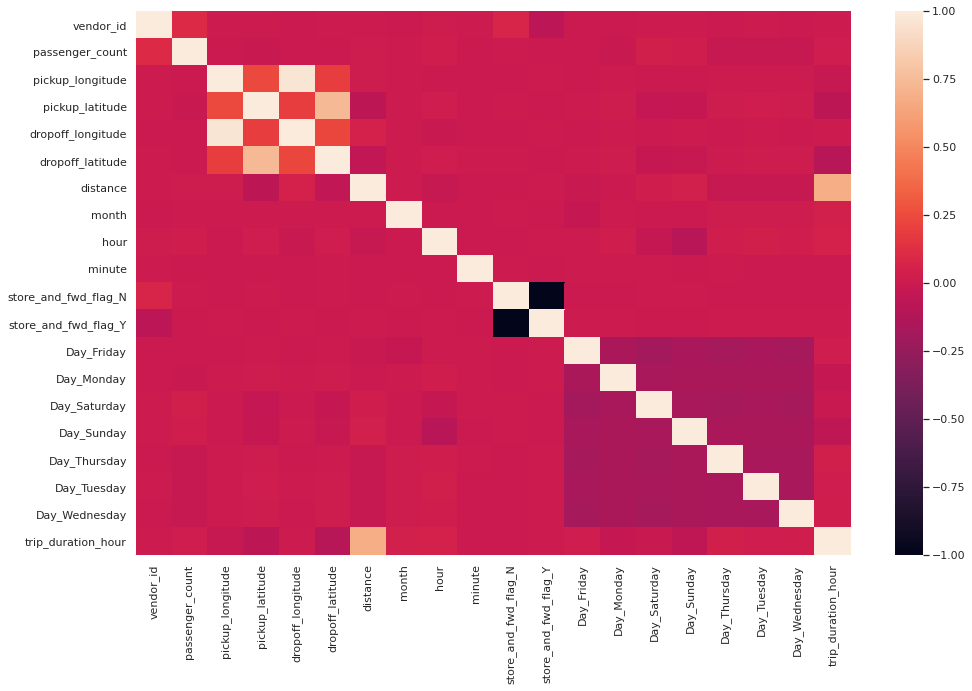

In [ ]:
plt.figure (figsize= (16,10))
sns.heatmap(trip_data.corr())

In [ ]:

reg = LinearRegression().fit(X_train, y_train)

In [ ]:
reg.score(X_train, y_train)

0.4977717521753691

In [ ]:
y_pred_train = reg.predict(X_train)

In [ ]:
y_pred_test = reg.predict(X_test)

In [ ]:
#Train set metrics
Ltr_MSE  = mean_squared_error((y_train), (y_pred_train))
print("MSE :" , Ltr_MSE)

Ltr_RMSE = np.sqrt(Ltr_MSE)

print("RMSE :" ,Ltr_RMSE)

Ltr_r2 = r2_score((y_train), (y_pred_train))
print("R2 :" ,Ltr_r2)
Ltr_ar2 = 1-(1-r2_score((y_train), (y_pred_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Adjusted R2 : ",Ltr_ar2)

MSE : 0.005544800863815122
RMSE : 0.07446341963551716
R2 : 0.49777175217536906
Adjusted R2 :  0.4976524431392517


In [ ]:
#Test set metrics
Lte_MSE  = mean_squared_error((y_test), (y_pred_test))
print("MSE :" , Lte_MSE)

Lte_RMSE = np.sqrt(Lte_MSE)
print("RMSE :" ,Lte_RMSE)

Lte_r2 = r2_score((y_test), (y_pred_test))
print("R2 :" ,Lte_r2)
Lte_ar2 = 1-(1-r2_score((y_test), (y_pred_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Adjusted R2 : ",Lte_ar2)

MSE : 0.0054712642758744994
RMSE : 0.07396799494291095
R2 : 0.49593024351436577
Adjusted R2 :  0.4954508979000902


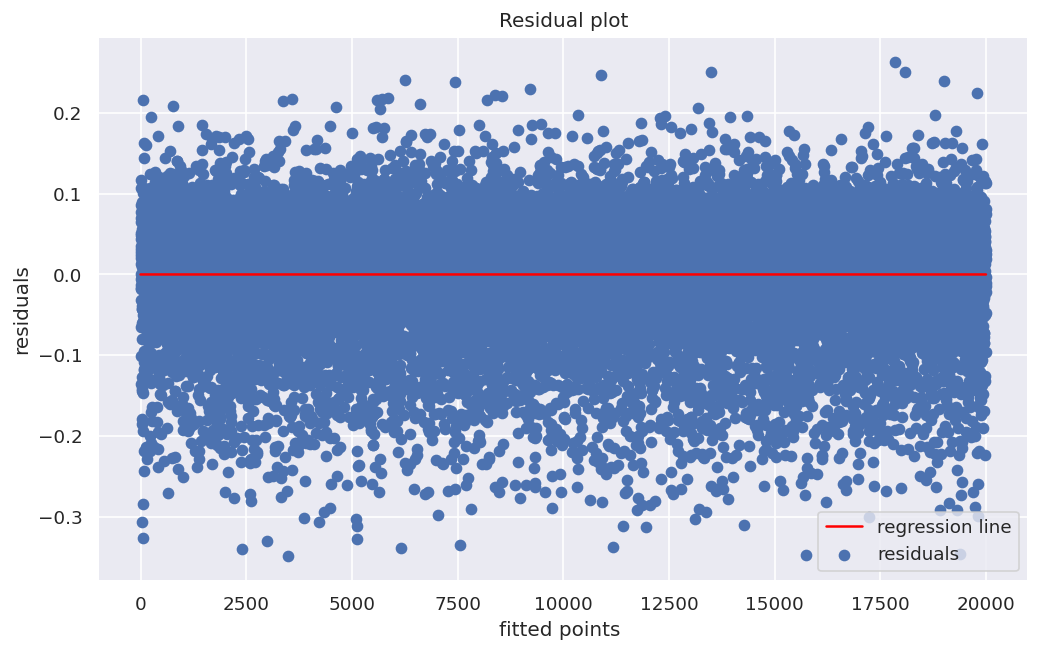

In [ ]:
residuals=y_pred_test-y_test

plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
f = range(0,len(y_test))
k = [0 for i in range(0,len(y_test))]
plt.scatter( f, residuals, label = 'residuals')
plt.plot( f, k , color = 'red', label = 'regression line' )
plt.xlabel('fitted points ')
plt.ylabel('residuals')
plt.title('Residual plot')
plt.legend()

DECISION TREE

In [ ]:
# Maximum depth of trees
max_depth = [4,6,8,10]

# Minimum number of samples required to split a node
min_samples_split = [10,20,30]

# Minimum number of samples required at each leaf node
min_samples_leaf = [10,16,20]

# HYperparameter Grid
param_dt = {
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
dt_model = DecisionTreeRegressor()

# Grid search
dt_grid = GridSearchCV(estimator=dt_model,
                       param_grid = param_dt,
                       cv = 5, verbose=2, scoring='r2')

dt_grid.fit(X_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=10 ..........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=10, total=   0.3s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=10 ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=10, total=   0.3s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=10 ..........
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=10, total=   0.2s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=10 ..........
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=10, total=   0.3s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=10 ..........
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=10, total=   0.2s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=20 ..........
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=20, total=   0.3s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=20 ..........
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=20, total=   0.3s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=20 ..........
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=20, total=   0.2s
[CV] max_depth=4, min_samples_leaf=10, min

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [4, 6, 8, 10],
                         'min_samples_leaf': [10, 16, 20],
                         'min_samples_split

In [ ]:
dt_grid.best_score_

0.6086109666577687

In [ ]:
dt_grid.best_score_

0.6086109666577687

In [ ]:
dt_grid.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=20, min_samples_split=30,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
dt_optimal_model =dt_grid.best_estimator_

In [ ]:

y_pred_dt_test=dt_optimal_model.predict(X_test)
y_pred_dt_train=dt_optimal_model.predict(X_train)

In [ ]:

y_pred_dt_test=dt_optimal_model.predict(X_test)
y_pred_dt_train=dt_optimal_model.predict(X_train)

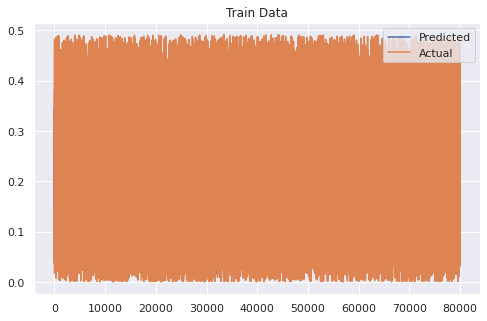

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Train Data')
plt.plot(y_pred_dt_train)
plt.plot(np.array(y_train))
plt.legend(["Predicted","Actual"])
plt.show()

In [ ]:

MSE  = mean_squared_error(y_train, y_pred_dt_train)
print("Train MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Train RMSE :" ,RMSE)

r2 = r2_score(y_train, y_pred_dt_train)
print("Train R2 :" ,r2)
print("Train Adjusted R2 : ",1-(1-r2_score(y_train, y_pred_dt_train))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)))

Train MSE : 0.003933693284929908
Train RMSE : 0.0627191620234989
Train R2 : 0.6437001193563989
Train Adjusted R2 :  0.6436154769741506


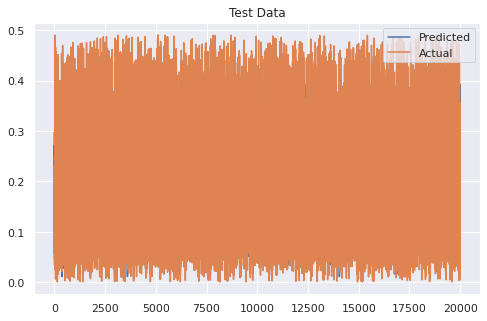

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Test Data')
plt.plot(y_pred_dt_test)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()

In [ ]:
MSE  = mean_squared_error(y_test, y_pred_dt_test)
print("Test MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Test RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_dt_test)
print("Test R2 :" ,r2)
print("Test Adjusted R2 : ",1-(1-r2_score(y_test, y_pred_dt_test))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

Test MSE : 0.004235598377226902
Test RMSE : 0.0650814749158845
Test R2 : 0.609772634819681
Test Adjusted R2 :  0.6094015477356758


In [ ]:
X_train.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'distance', 'month', 'hour',
       'minute', 'store_and_fwd_flag_N', 'store_and_fwd_flag_Y', 'Day_Friday',
       'Day_Monday', 'Day_Saturday', 'Day_Sunday', 'Day_Thursday',
       'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')

In [ ]:

dt_optimal_model.feature_importances_

array([9.38968142e-04, 4.43967868e-05, 9.12159374e-03, 4.52624602e-03,
       1.10952278e-02, 5.23422795e-02, 7.95299356e-01, 1.13750226e-03,
       9.12148562e-02, 1.38090212e-03, 0.00000000e+00, 0.00000000e+00,
       1.15545919e-03, 1.85697790e-03, 1.27165769e-02, 1.60198960e-02,
       7.31804693e-04, 1.33113813e-04, 2.84843170e-04])

In [ ]:

importances = dt_optimal_model.feature_importances_

importance_dict = {'Feature' : list(X_train.columns),
                   'Feature Importance' : importances}

importance_df = pd.DataFrame(importance_dict)

In [ ]:
importance_df.sort_values(by=['Feature Importance'],ascending=False,inplace=True)
importance_df

Feature  Feature Importance
6               distance                0.80
8                   hour                0.09
5       dropoff_latitude                0.05
15            Day_Sunday                0.02
2       pickup_longitude                0.01
4      dropoff_longitude                0.01
14          Day_Saturday                0.01
0              vendor_id                0.00
12            Day_Friday                0.00
17           Day_Tuesday                0.00
16          Day_Thursday                0.00
13            Day_Monday                0.00
9                 minute                0.00
11  store_and_fwd_flag_Y                0.00
10  store_and_fwd_flag_N                0.00
1        passenger_count                0.00
7                  month                0.00
3        pickup_latitude                0.00
18         Day_Wednesday                0.00

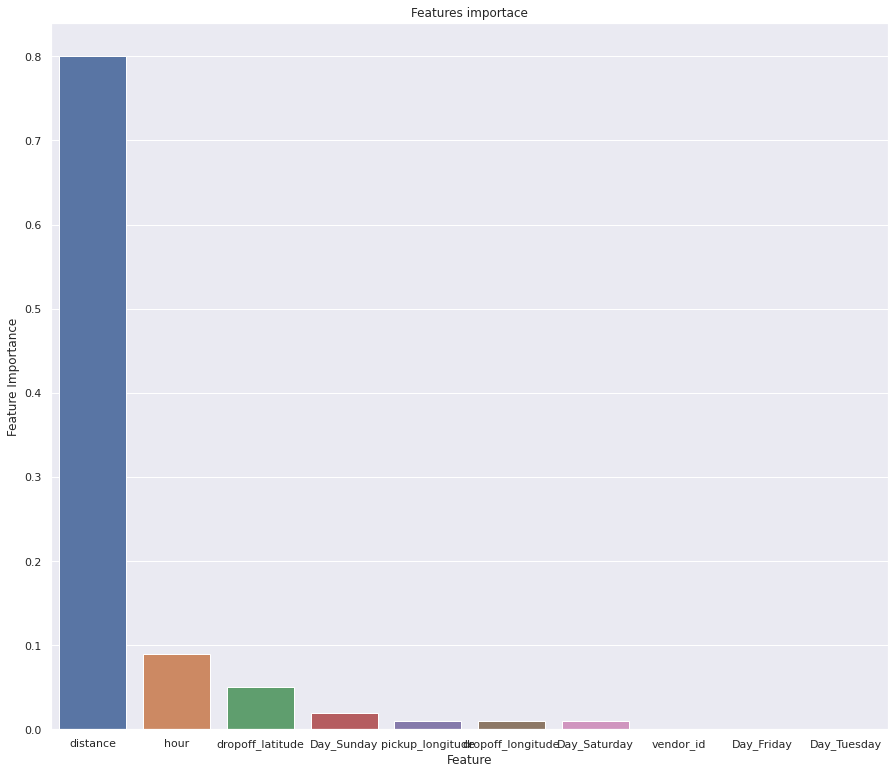

In [ ]:
plt.figure(figsize=(15,13))
plt.title('Features importace')
sns.barplot(x='Feature',y="Feature Importance",data=importance_df[:10])

In [ ]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

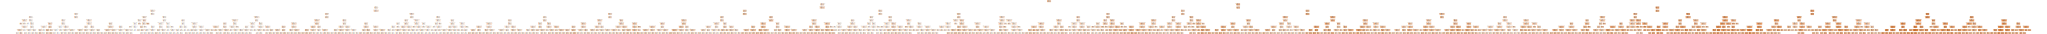

In [ ]:
graph = Source(tree.export_graphviz(dt_optimal_model, out_file=None,feature_names=X_train.columns, filled = True))
display(SVG(graph.pipe(format='svg')))

In [ ]:
from sklearn.model_selection import GridSearchCV
### Cross validation
lasso = Lasso()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='r2', cv=5)
lasso_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 60, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [ ]:
lasso_regressor.score(X_train, y_train)

0.4977738411443353

In [ ]:
print("The best fit alpha value is found out to be :" ,lasso_regressor.best_params_)
print("\nUsing ",lasso_regressor.best_params_, " the negative mean squared error is: ", lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 1e-05}

Using  {'alpha': 1e-05}  the negative mean squared error is:  0.4974340979499825


In [ ]:
y_pred_lasso = lasso_regressor.predict(X_test)
y_pred_lasso_train = lasso_regressor.predict(X_train)

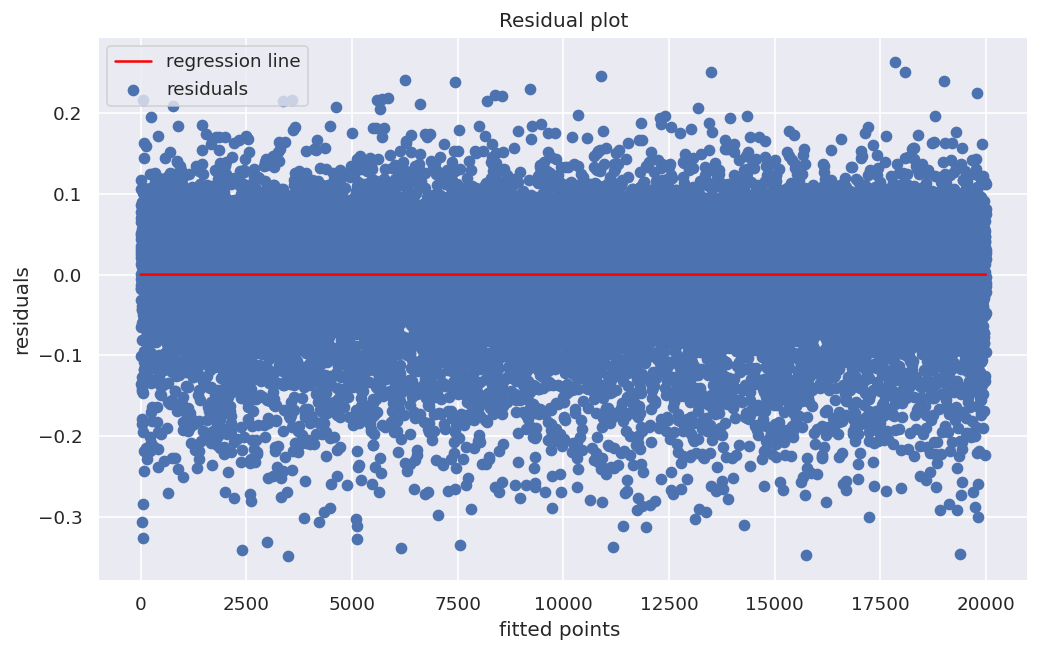

In [ ]:
#Heteroskedasticity
residuals=y_pred_lasso-y_test

plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
f = range(0,len(y_test))
k = [0 for i in range(0,len(y_test))]
plt.scatter( f, residuals, label = 'residuals')
plt.plot( f, k , color = 'red', label = 'regression line' )
plt.xlabel('fitted points ')
plt.ylabel('residuals')
plt.title('Residual plot')
plt.legend()

In [ ]:
MSE  = mean_squared_error(y_train, y_pred_lasso_train)
print("Train MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Train RMSE :" ,RMSE)

r2 = r2_score(y_train, y_pred_lasso_train)
print("Train R2 :" ,r2)
print("Train Adjusted R2 : ",1-(1-r2_score(y_train, y_pred_lasso_train))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)))

Train MSE : 0.005544777800761662
Train RMSE : 0.07446326477372357
Train R2 : 0.4977738411443353
Train Adjusted R2 :  0.4976545326044721


In [ ]:
MSE  = mean_squared_error(y_test, y_pred_lasso)
print("Test MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Test RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_lasso)
print("Test R2 :" ,r2)
print("Test Adjusted R2 : ",1-(1-r2_score(y_test, y_pred_lasso))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

Test MSE : 0.005470898039694827
Test RMSE : 0.07396551926198333
Test R2 : 0.4959639849994403
Test Adjusted R2 :  0.495484671471662


Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge
### Cross validation
ridge = Ridge()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='r2', cv=5)
ridge_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 60, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [ ]:
ridge_regressor.score(X_train, y_train)

0.49777368658851906

In [ ]:
print("The best fit alpha value is found out to be :" ,ridge_regressor.best_params_)
print("\nUsing ",ridge_regressor.best_params_, " the negative mean squared error is: ", lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 60}

Using  {'alpha': 60}  the negative mean squared error is:  0.4974340979499825


In [ ]:

y_pred_ridge_test = ridge_regressor.predict(X_test)
y_pred_ridge_train=ridge_regressor.predict(X_train)

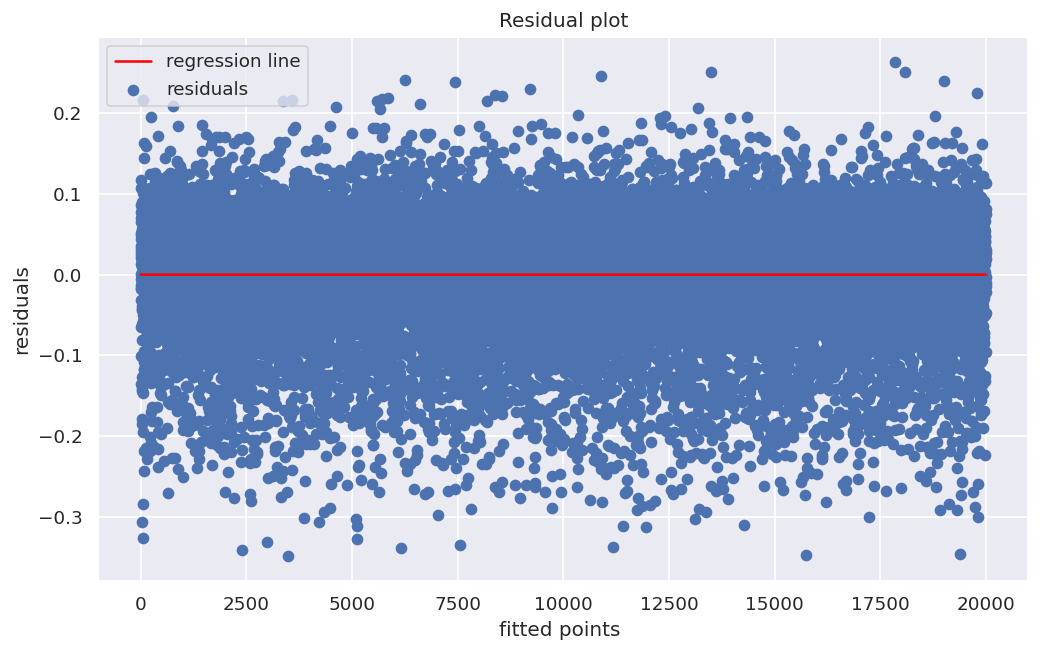

In [ ]:
#Heteroskedasticity
residuals=y_pred_ridge_test-y_test

plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
f = range(0,len(y_test))
k = [0 for i in range(0,len(y_test))]
plt.scatter( f, residuals, label = 'residuals')
plt.plot( f, k , color = 'red', label = 'regression line' )
plt.xlabel('fitted points ')
plt.ylabel('residuals')
plt.title('Residual plot')
plt.legend()

In [ ]:
MSE  = mean_squared_error(y_train, y_pred_ridge_train)
print("Train MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Train RMSE :" ,RMSE)

r2 = r2_score(y_train, y_pred_ridge_train)
print("Train R2 :" ,r2)
print("Train Adjusted R2 : ",1-(1-r2_score(y_train, y_pred_ridge_train))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)))

Train MSE : 0.005544779507119731
Train RMSE : 0.07446327623143996
Train R2 : 0.49777368658851906
Train Adjusted R2 :  0.4976543780119397


In [ ]:
MSE  = mean_squared_error(y_test, y_pred_ridge_test)
print("Test MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Test RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_ridge_test)
print("Test R2 :" ,r2)
print("Test Adjusted R2 : ",1-(1-r2_score(y_test, y_pred_ridge_test))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

Test MSE : 0.00547087496250748
Test RMSE : 0.07396536326218833
Test R2 : 0.4959661111099004
Test Adjusted R2 :  0.4954867996039489


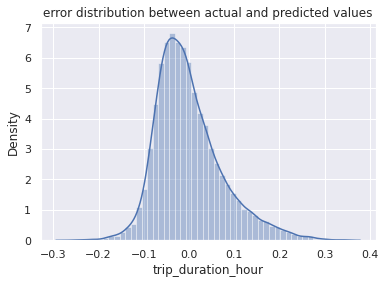

In [ ]:
sns.distplot(y_test - y_pred_ridge_test ).set_title("error distribution between actual and predicted values")
plt.show()

XGBoost

In [ ]:
# Number of trees
n_estimators = [50,100,120]

# Maximum depth of trees
max_depth = [5,7,9]
min_samples_split = [40,50]
#learning_rate=[0.1,0.3,0.5]

# HYperparameter Grid
param_xgb = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
             'min_samples_split':min_samples_split
              }

In [ ]:
# Create an instance of the  XGBRegressor
import xgboost as xgb
xgb_model = xgb.XGBRegressor()

# Grid search
xgb_grid = GridSearchCV(estimator=xgb_model,param_grid = param_xgb,cv = 3, verbose=2,scoring="r2")

xgb_grid.fit(X_train,y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] max_depth=5, min_samples_split=40, n_estimators=50 ..............
[16:39:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=5, min_samples_split=40, n_estimators=50, total=   3.8s
[CV] max_depth=5, min_samples_split=40, n_estimators=50 ..............
[16:40:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV]  max_depth=5, min_samples_split=40, n_estimators=50, total=   3.7s
[CV] max_depth=5, min_samples_split=40, n_estimators=50 ..............
[16:40:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  max_depth=5, min_samples_split=40, n_estimators=50, total=   3.6s
[CV] max_depth=5, min_samples_split=40, n_estimators=100 .............
[16:40:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  max_depth=5, min_samples_split=40, n_estimators=100, total=   7.2s
[CV] max_depth=5, min_samples_split=40, n_estimators=100 .............
[16:40:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  max_depth=5, min_samples_split=40, n_estimators=100, total=   7.1s
[CV] max_depth=5, min_samples_split=40, n_estimators=100 .............
[16:40:22] WARNING: /workspace/src/objective/

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  8.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [5, 7, 9], 'min_samples_split': [40, 50],
                         'n_estimators': [50, 100, 1

In [ ]:
xgb_grid.best_score_

0.7026666685416957

In [ ]:
xgb_grid.best_params_

{'max_depth': 9, 'min_samples_split': 40, 'n_estimators': 120}

In [ ]:
xgb_optimal_model =xgb_grid.best_estimator_

In [ ]:
y_pred_xgb_test=xgb_optimal_model.predict(X_test)
y_pred_xgb_train=xgb_optimal_model.predict(X_train)


In [ ]:
MSE  = mean_squared_error(y_train, y_pred_xgb_train)
print("Train MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Train RMSE :" ,RMSE)

r2 = r2_score(y_train, y_pred_xgb_train)
print("Train R2 :" ,r2)
print("Train Adjusted R2 : ",1-(1-r2_score((y_train), (y_pred_xgb_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)))

Train MSE : 0.001963513255289278
Train RMSE : 0.044311547651704496
Train R2 : 0.8221519859766687
Train Adjusted R2 :  0.8221097365109717


In [ ]:
MSE  = mean_squared_error(y_test, y_pred_xgb_test)
print("Test MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Test RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_xgb_test)
print("Test R2 :" ,r2)
print("Test Adjusted R2 : ",1-(1-r2_score((y_test), (y_pred_xgb_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

Test MSE : 0.0031445622329224813
Test RMSE : 0.056076396397436966
Test R2 : 0.7102902292633624
Test Adjusted R2 :  0.7100147294813806


In [ ]:
X_train.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'distance', 'month', 'hour',
       'minute', 'store_and_fwd_flag_N', 'store_and_fwd_flag_Y', 'Day_Friday',
       'Day_Monday', 'Day_Saturday', 'Day_Sunday', 'Day_Thursday',
       'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')

In [ ]:
xgb_optimal_model.feature_importances_

array([0.00625629, 0.00633789, 0.01918391, 0.01993586, 0.02414751,
       0.04146331, 0.43513972, 0.01926788, 0.08249865, 0.01088677,
       0.01079909, 0.        , 0.01828299, 0.05281273, 0.07541084,
       0.10604851, 0.02390587, 0.02580334, 0.02181888], dtype=float32)

In [ ]:
importances = xgb_optimal_model.feature_importances_

importance_dict = {'Feature' : list(X_train.columns),
                   'Feature Importance' : importances}

importance_df = pd.DataFrame(importance_dict)

In [ ]:
importance_df.sort_values(by=['Feature Importance'],ascending=False,inplace=True)
importance_df

Feature  Feature Importance
6               distance            0.435140
15            Day_Sunday            0.106049
8                   hour            0.082499
14          Day_Saturday            0.075411
13            Day_Monday            0.052813
5       dropoff_latitude            0.041463
17           Day_Tuesday            0.025803
4      dropoff_longitude            0.024148
16          Day_Thursday            0.023906
18         Day_Wednesday            0.021819
3        pickup_latitude            0.019936
7                  month            0.019268
2       pickup_longitude            0.019184
12            Day_Friday            0.018283
9                 minute            0.010887
10  store_and_fwd_flag_N            0.010799
1        passenger_count            0.006338
0              vendor_id            0.006256
11  store_and_fwd_flag_Y            0.000000

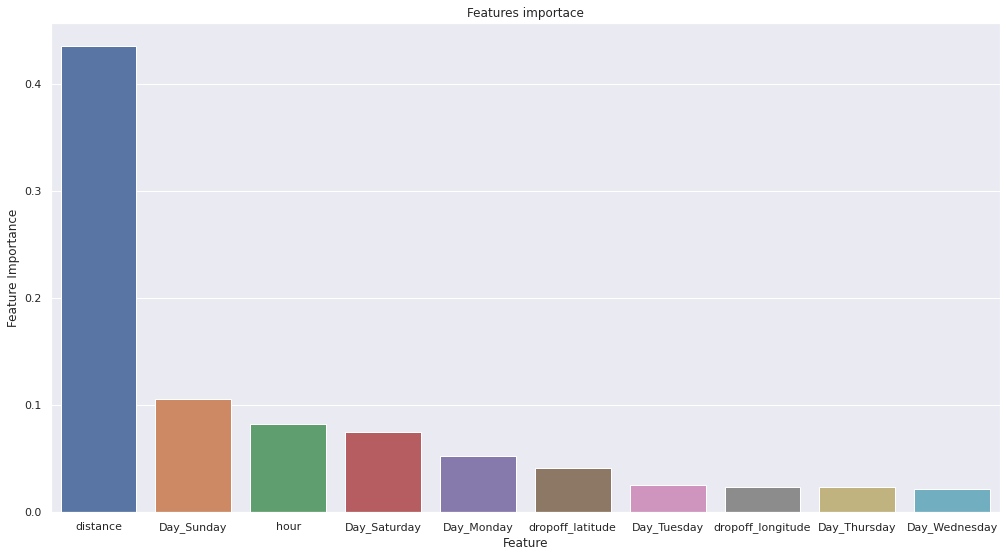

In [ ]:
plt.figure(figsize=(17,9))
plt.title('Features importace')
sns.barplot(x='Feature',y="Feature Importance",data=importance_df[:10])

GradientBoosting

In [ ]:
# Number of trees
n_estimators = [100,120]

# Maximum depth of trees
max_depth = [5,8,10]

# Minimum number of samples required to split a node
min_samples_split = [50,80]

# Minimum number of samples required at each leaf node
min_samples_leaf = [40,50]


# HYperparameter Grid
param_gb = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

In [ ]:
# Create an instance of the  GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
gb_model=GradientBoostingRegressor()

# Grid search
gb_grid = GridSearchCV(estimator=gb_model,
                       param_grid = param_gb,
                       cv = 3, verbose=2, scoring='r2')

gb_grid.fit(X_train,y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=  24.3s
[CV] max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.3s remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=  24.2s
[CV] max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=100 
[CV]  max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=  24.1s
[CV] max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=120 
[CV]  max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=120, total=  28.9s
[CV] max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=120 
[CV]  max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=120, total=  28.7s
[CV] max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=120 
[CV]  max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=120, total=  28.7s
[CV] max_depth=5, min_samples_leaf=40, min_samples_split=80, n_estimators=100 
[CV]  max_depth=5, min_samples_leaf=40, min_samples_split=80, n_estimators=100, total=  24.1s
[CV] max_depth=5, min_samples_leaf=40, mi

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 46.9min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_n...ge=None,
                    

In [ ]:
gb_grid.best_params_

{'max_depth': 10,
 'min_samples_leaf': 50,
 'min_samples_split': 80,
 'n_estimators': 120}

In [ ]:

gb_grid.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=10,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=50, min_samples_split=80,
                          min_weight_fraction_leaf=0.0, n_estimators=120,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
gb_optimal_model = gb_grid.best_estimator_

In [ ]:
y_preds_gb = gb_optimal_model.predict(X_test)
y_pred_gb_train=gb_optimal_model.predict(X_train)

In [ ]:
MSE  = mean_squared_error(y_train, y_pred_gb_train)
print("Train MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Train RMSE :" ,RMSE)

r2 = r2_score(y_train, y_pred_gb_train)
print("Train R2 :" ,r2)
print("Train Adjusted R2 : ",1-(1-r2_score((y_train), (y_pred_gb_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)))

Train MSE : 0.0022675373651197994
Train RMSE : 0.04761866614175369
Train R2 : 0.7946145685424261
Train Adjusted R2 :  0.7945657773046455


In [ ]:
MSE  = mean_squared_error(y_test, y_preds_gb)
print("Test MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Test RMSE :" ,RMSE)

r2 = r2_score(y_test, y_preds_gb)
print("Test R2 :" ,r2)
print("Test Adjusted R2 : ",1-(1-r2_score((y_test), (y_preds_gb)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

Test MSE : 0.0031215829393205297
Test RMSE : 0.0558711279581908
Test R2 : 0.7124073207336508
Test Adjusted R2 :  0.712133834201816


In [ ]:

xgb_optimal_model.feature_importances_

array([0.00625629, 0.00633789, 0.01918391, 0.01993586, 0.02414751,
       0.04146331, 0.43513972, 0.01926788, 0.08249865, 0.01088677,
       0.01079909, 0.        , 0.01828299, 0.05281273, 0.07541084,
       0.10604851, 0.02390587, 0.02580334, 0.02181888], dtype=float32)

In [ ]:
importances = gb_optimal_model.feature_importances_

importance_dict = {'Feature' : list(X_train.columns),
                   'Feature Importance' : importances}

importance_df = pd.DataFrame(importance_dict)

In [ ]:
importance_df.sort_values(by=['Feature Importance'],ascending=False,inplace=True)
importance_df

Feature  Feature Importance
6               distance            0.657715
8                   hour            0.089069
5       dropoff_latitude            0.074074
4      dropoff_longitude            0.044276
2       pickup_longitude            0.042346
3        pickup_latitude            0.034408
15            Day_Sunday            0.015044
14          Day_Saturday            0.013166
7                  month            0.008119
9                 minute            0.007355
13            Day_Monday            0.004189
12            Day_Friday            0.002055
0              vendor_id            0.001982
16          Day_Thursday            0.001969
18         Day_Wednesday            0.001802
17           Day_Tuesday            0.001761
1        passenger_count            0.000664
11  store_and_fwd_flag_Y            0.000005
10  store_and_fwd_flag_N            0.000000

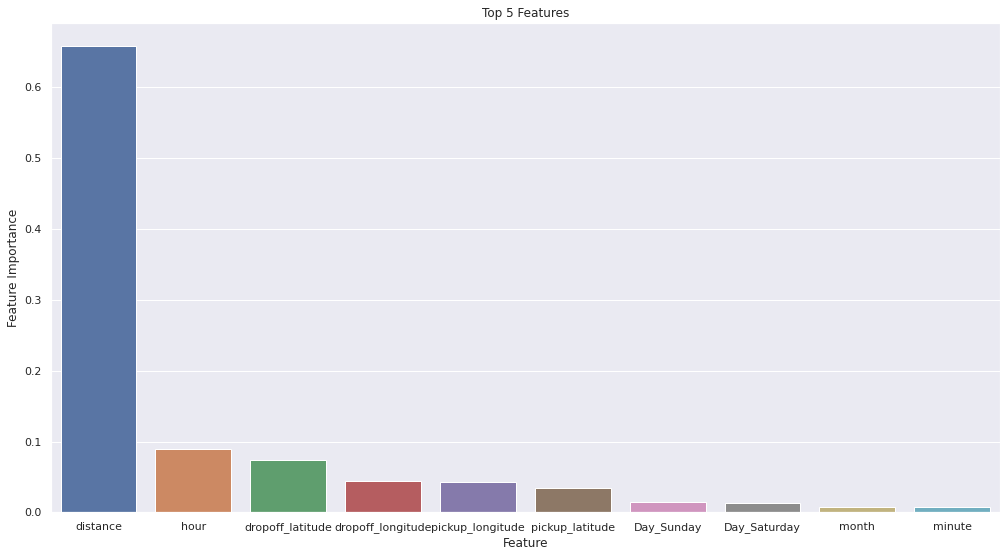

In [ ]:
plt.figure(figsize=(17,9))
plt.title('Top 5 Features')
sns.barplot(x='Feature',y="Feature Importance",data=importance_df[:10])

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
# Applying LightGBM
n_estimator=[5,10,20] # No. of tree
max_depth=[5,7,9] # max depth of tree
min_samples_split=[40,50]
params={"n_estimator":n_estimator,"max_depth":max_depth,"min_samples_split":min_samples_split}
lgb=LGBMRegressor()
gs_lgb=GridSearchCV(lgb,params,cv=3,verbose=2,scoring='r2')
gs_lgb.fit(X_train,y_train)
print(gs_lgb.best_score_)
print(gs_lgb.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] max_depth=5, min_samples_split=40, n_estimator=5 ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . max_depth=5, min_samples_split=40, n_estimator=5, total=   1.2s
[CV] max_depth=5, min_samples_split=40, n_estimator=5 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] . max_depth=5, min_samples_split=40, n_estimator=5, total=   1.2s
[CV] max_depth=5, min_samples_split=40, n_estimator=5 ................
[CV] . max_depth=5, min_samples_split=40, n_estimator=5, total=   1.2s
[CV] max_depth=5, min_samples_split=40, n_estimator=10 ...............
[CV]  max_depth=5, min_samples_split=40, n_estimator=10, total=   1.2s
[CV] max_depth=5, min_samples_split=40, n_estimator=10 ...............
[CV]  max_depth=5, min_samples_split=40, n_estimator=10, total=   1.2s
[CV] max_depth=5, min_samples_split=40, n_estimator=10 ...............
[CV]  max_depth=5, min_samples_split=40, n_estimator=10, total=   1.2s
[CV] max_depth=5, min_samples_split=40, n_estimator=20 ...............
[CV]  max_depth=5, min_samples_split=40, n_estimator=20, total=   1.2s
[CV] max_depth=5, min_samples_split=40, n_estimator=20 ...............
[CV]  max_depth=5, min_samples_split=40, n_estimator=20, total=   1.2s
[CV] max_depth=5, min_samples_split=40, n_estimator=20 ...............
[CV]  

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  1.1min finished


0.6849279249121748
{'max_depth': 9, 'min_samples_split': 40, 'n_estimator': 5}


In [ ]:
gs_lgb.best_estimator_

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=9,
              min_child_samples=20, min_child_weight=0.001,
              min_samples_split=40, min_split_gain=0.0, n_estimator=5,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
gs_lgb_opt_model = gs_lgb.best_estimator_

In [ ]:
y_preds_lgb = gs_lgb_opt_model.predict(X_test)
y_pred_lgb_train=gs_lgb_opt_model.predict(X_train)

In [ ]:
MSE  = mean_squared_error(y_train, y_pred_lgb_train)
print("Train MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Train RMSE :" ,RMSE)

r2 = r2_score(y_train, y_pred_lgb_train)
print("Train R2 :" ,r2)
print("Train Adjusted R2 : ",1-(1-r2_score((y_train), (y_pred_lgb_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)))

Train MSE : 0.0032980298940813377
Train RMSE : 0.057428476334318135
Train R2 : 0.7012762377478683
Train Adjusted R2 :  0.7012052731131748


In [ ]:
MSE  = mean_squared_error(y_test, y_preds_lgb)
print("Test MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Test RMSE :" ,RMSE)

r2 = r2_score(y_test, y_preds_lgb)
print("Test R2 :" ,r2)
print("Test Adjusted R2 : ",1-(1-r2_score((y_test), (y_preds_lgb)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

Test MSE : 0.003418832582409957
Test RMSE : 0.058470784007142895
Test R2 : 0.6850215927460219
Test Adjusted R2 :  0.6847220637301148


In [ ]:
gs_lgb_opt_model.feature_importances_

array([ 28,  13, 389, 331, 402, 497, 349,  81, 503,  54,   0,   0,  21,
        55, 120, 100,  17,  24,  16])

In [ ]:
importances = gs_lgb_opt_model.feature_importances_

importance_dict = {'Feature' : list(X_train.columns),
                   'Feature Importance' : importances}

importance_df = pd.DataFrame(importance_dict)

In [ ]:
importance_df.sort_values(by=['Feature Importance'],ascending=False,inplace=True)
importance_df

Feature  Feature Importance
8                   hour                 503
5       dropoff_latitude                 497
4      dropoff_longitude                 402
2       pickup_longitude                 389
6               distance                 349
3        pickup_latitude                 331
14          Day_Saturday                 120
15            Day_Sunday                 100
7                  month                  81
13            Day_Monday                  55
9                 minute                  54
0              vendor_id                  28
17           Day_Tuesday                  24
12            Day_Friday                  21
16          Day_Thursday                  17
18         Day_Wednesday                  16
1        passenger_count                  13
11  store_and_fwd_flag_Y                   0
10  store_and_fwd_flag_N                   0

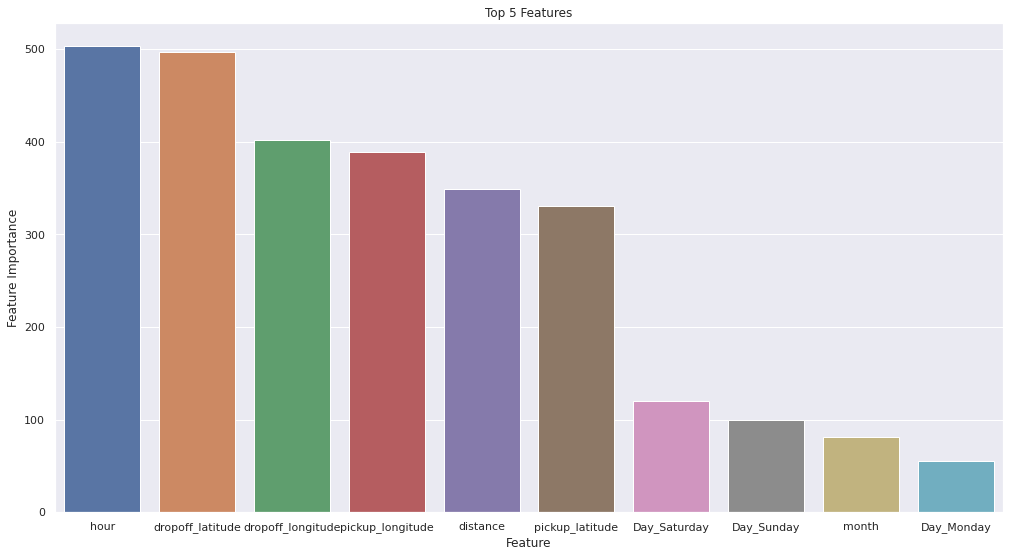

In [ ]:
plt.figure(figsize=(17,9))
plt.title('Top 5 Features')
sns.barplot(x='Feature',y="Feature Importance",data=importance_df[:10])

Model Summary

In [ ]:
#Train data

from prettytable import PrettyTable
train = PrettyTable(['SL NO',"MODEL_NAME", "Train MSE", "Train RMSE",'Train R^2','Train Adjusted R^2'])
train.add_row(['1','Linear Regression','0.005467021181864388','0.07393930742077848','0.5042456435975543','0.5041278724951332'])
train.add_row(['2','Lasso Regression','0.005494826110976565','0.07412709431089665','0.49994898506301866','0.4998301932490177'])
train.add_row(['3','Ridge Regression ','0.005494824127596807','0.07412708093265785','0.4999491655584595','0.49983037378733686'])
train.add_row(['4','DecisionTree Regressor','0.003908733073695245','0.06251986143374956','0.6442897552818683','0.6442052529731706'])
train.add_row(['5','XGBRegressor','0.001996779863964856','0.044685342831457114','0.8182850963041854','0.8182419282225373'])
train.add_row(['6','GradientBoosting','0.002278863599313375','0.04773744441539969','0.7926143552635426','0.7925650888563159'])
train.add_row(['7','LightGBM','0.0032980298940813377','0.057428476334318135','0.7012762377478683',' 0.7012052731131748'])
print(train)

+-------+------------------------+-----------------------+----------------------+---------------------+---------------------+
| SL NO |       MODEL_NAME       |       Train MSE       |      Train RMSE      |      Train R^2      |  Train Adjusted R^2 |
+-------+------------------------+-----------------------+----------------------+---------------------+---------------------+
|   1   |   Linear Regression    |  0.005467021181864388 | 0.07393930742077848  |  0.5042456435975543 |  0.5041278724951332 |
|   2   |    Lasso Regression    |  0.005494826110976565 | 0.07412709431089665  | 0.49994898506301866 |  0.4998301932490177 |
|   3   |   Ridge Regression     |  0.005494824127596807 | 0.07412708093265785  |  0.4999491655584595 | 0.49983037378733686 |
|   4   | DecisionTree Regressor |  0.003908733073695245 | 0.06251986143374956  |  0.6442897552818683 |  0.6442052529731706 |
|   5   |      XGBRegressor      |  0.001996779863964856 | 0.044685342831457114 |  0.8182850963041854 |  0.81824192822

In [ ]:
from prettytable import PrettyTable
test = PrettyTable(['SL NO',"MODEL_NAME", "Test MSE", "Test RMSE",'Test R^2','Test Adjusted R^2'])
test.add_row(['1','Linear Regression','0.005539358995881834',' 0.07442687012015105','0.48551298500777995','0.48502373309162117'])
test.add_row(['2','Lasso Regression','0.005448974432213879','0.07381716895285187','0.5030970331831028','0.502624502834278'])
test.add_row(['3','Ridge Regression ','0.005449008499105121','0.07381739970430495','0.5030939265545915','0.5026213932515153'])
test.add_row(['4','DecisionTree Regressor','0.004203945325941736','0.06483783868962426','0.6166337480963826',' 0.6162691855945723'])
test.add_row(['5','XGBRegressor','0.0031306995630522444','0.0559526546559879','0.7145051935101532','0.7142337019524301'])
test.add_row(['6','GradientBoosting','0.00311712671404449','0.05583123421566543','0.7157429289820318',' 0.7154726144500327'])
test.add_row(['7','LightGBM','0.003418832582409957','0.058470784007142895','0.6850215927460219','0.6847220637301148'])
print(test)

+-------+------------------------+-----------------------+----------------------+---------------------+---------------------+
| SL NO |       MODEL_NAME       |        Test MSE       |      Test RMSE       |       Test R^2      |  Test Adjusted R^2  |
+-------+------------------------+-----------------------+----------------------+---------------------+---------------------+
|   1   |   Linear Regression    |  0.005539358995881834 |  0.07442687012015105 | 0.48551298500777995 | 0.48502373309162117 |
|   2   |    Lasso Regression    |  0.005448974432213879 | 0.07381716895285187  |  0.5030970331831028 |  0.502624502834278  |
|   3   |   Ridge Regression     |  0.005449008499105121 | 0.07381739970430495  |  0.5030939265545915 |  0.5026213932515153 |
|   4   | DecisionTree Regressor |  0.004203945325941736 | 0.06483783868962426  |  0.6166337480963826 |  0.6162691855945723 |
|   5   |      XGBRegressor      | 0.0031306995630522444 |  0.0559526546559879  |  0.7145051935101532 |  0.71423370195

Hence we can conclude that Gradient boosting perform well.